In [1]:
import urllib.request
url = 'https://github.com/PiotrLachowicz/SieciProjekt/raw/main/archive.zip'
filename = 'archive.zip' ### sciezka do miejsca, gdzie chcesz zapisac baze danych
urllib.request.urlretrieve(url, filename)

('archive.zip', <http.client.HTTPMessage at 0x78770fe9f7f0>)

In [4]:
import zipfile
path = "/content/" ### gdzie chcesz, żeby dane zostały wypakowane
with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall(path)

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data_dir = path + 'Dataset/'

In [ ]:
# Definicja transformacji z normalizacją 0-1
transform = transforms.Compose([
    transforms.Resize((128, 128)),          # Zmiana rozmiaru obrazka na 128x128 pikseli
    transforms.ToTensor(),                  # Konwersja obrazka na tensor PyTorch [0, 1]
])

#Tworzymy nasz zbiór danych za pomocą ImageFolder
#dzięki temu od razu przyporządkuje nam etykiety obrazków
#według tego, w jakim folderze się znajdują
dataset = ImageFolder(root=data_dir, transform=transform)

# Przykładowe wyświetlenie informacji o dataset
print(f"Ilość obrazków w dataset: {len(dataset)}")
print(f"Ilość klas: {len(dataset.classes)}")
print(f"Klasy: {dataset.classes}")

# Przykładowe wyświetlenie jednego obrazka
index = 0
image, label = dataset[index]
print(f"Kształt obrazka: {image.shape}")
print(f"Etykieta: {label}")


Ilość obrazków w dataset: 6400
Ilość klas: 4
Klasy: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Kształt obrazka: torch.Size([3, 128, 128])
Etykieta: 0


In [ ]:
# Podział indeksów na treningowy, walidacyjny i testowy
from sklearn.model_selection import train_test_split
train_indices, rest_indices = train_test_split(range(len(dataset)), test_size=0.4, random_state=1234) # 60% zbior testowy
val_indices, test_indices = train_test_split(rest_indices, test_size=0.5, random_state=123) #po 20% zbior walidacyjny i zbior testowy

# Tworzenie zbiorów danych
train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Ustawienie DataLoader dla każdego zbioru
batch_size = 64
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


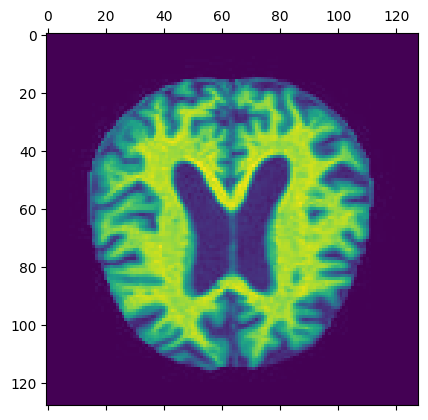

In [ ]:
a=np.array(dataset[0][0][0])
plt.matshow(a)
plt.show() # rysunek poglądowy

## Model 1

In [ ]:
in_channels = [3, 32, 64]
out_channels = in_channels[1:] + [80]

In [ ]:
import torch.nn as nn

model1 = nn.Sequential()
model1.add_module('conv1', nn.Conv2d(in_channels=in_channels[0], out_channels=out_channels[0], kernel_size=11, padding=5))
model1.add_module('relu1', nn.ReLU())
model1.add_module('pool1', nn.MaxPool2d(kernel_size=4))
model1.add_module('conv2', nn.Conv2d(in_channels=in_channels[1], out_channels=out_channels[1], kernel_size=7, padding=3))
model1.add_module('relu2', nn.ReLU())
model1.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model1.add_module('conv3', nn.Conv2d(in_channels=in_channels[2], out_channels=out_channels[2], kernel_size=5, padding=2))
model1.add_module('relu3', nn.ReLU())
model1.add_module('pool3', nn.MaxPool2d(kernel_size=2))

In [ ]:
x = torch.ones((4, 3, 128, 128)) # batch=4, 3 kanały, obraz 128x128
model1(x).shape # jako wynik dostajemy 80 map rozmiaru 8x8

torch.Size([4, 80, 8, 8])

In [ ]:
model1.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, 128, 128))
model1(x).shape

torch.Size([4, 5120])

In [ ]:
model1.add_module('fc1', nn.Linear(5120, 1024))
model1.add_module('relu4', nn.ReLU())
model1.add_module('dropout', nn.Dropout(p=0.5))

model1.add_module('fc2', nn.Linear(1024, 4))  # 4 etykiety


In [ ]:
if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")
else:
    print('OK')

OK


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model1, num_epochs, train_dl, valid_dl)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 accuracy: 0.4875 val_accuracy: 0.4781
Epoch 2 accuracy: 0.4958 val_accuracy: 0.4781
Epoch 3 accuracy: 0.5122 val_accuracy: 0.5297
Epoch 4 accuracy: 0.5367 val_accuracy: 0.5617
Epoch 5 accuracy: 0.5674 val_accuracy: 0.5797
Epoch 6 accuracy: 0.5763 val_accuracy: 0.5852
Epoch 7 accuracy: 0.5859 val_accuracy: 0.6180
Epoch 8 accuracy: 0.6125 val_accuracy: 0.6305
Epoch 9 accuracy: 0.6380 val_accuracy: 0.6445
Epoch 10 accuracy: 0.6539 val_accuracy: 0.6102
Epoch 11 accuracy: 0.6794 val_accuracy: 0.6773
Epoch 12 accuracy: 0.7141 val_accuracy: 0.7008
Epoch 13 accuracy: 0.7479 val_accuracy: 0.7250
Epoch 14 accuracy: 0.8008 val_accuracy: 0.7719
Epoch 15 accuracy: 0.8242 val_accuracy: 0.7977
Epoch 16 accuracy: 0.8573 val_accuracy: 0.7984
Epoch 17 accuracy: 0.8901 val_accuracy: 0.8406
Epoch 18 accuracy: 0.9242 val_accuracy: 0.8484
Epoch 19 accuracy: 0.9328 val_accuracy: 0.8469
Epoch 20 accuracy: 0.9518 val_accuracy: 0.8844


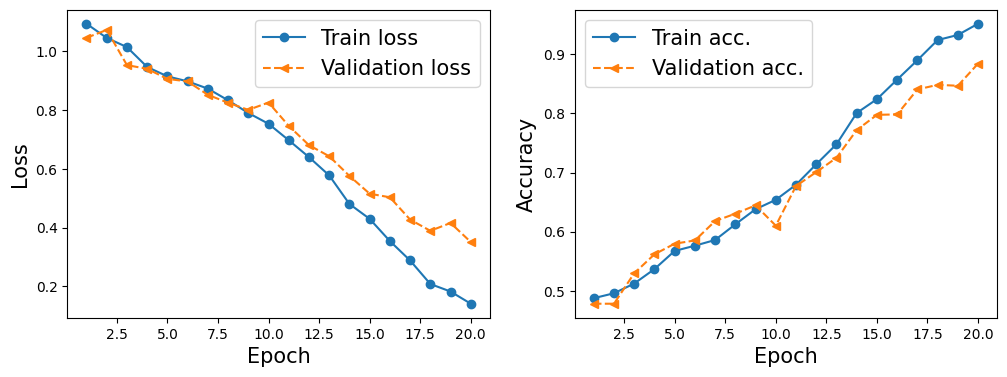

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

Idzie bardzo dobrze. Doszkalamy.

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist_doszko = train(model1, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9560 val_accuracy: 0.8938
Epoch 2 accuracy: 0.9711 val_accuracy: 0.8898
Epoch 3 accuracy: 0.9745 val_accuracy: 0.8953
Epoch 4 accuracy: 0.9836 val_accuracy: 0.8828
Epoch 5 accuracy: 0.9763 val_accuracy: 0.8852
Epoch 6 accuracy: 0.9826 val_accuracy: 0.9055
Epoch 7 accuracy: 0.9854 val_accuracy: 0.9062
Epoch 8 accuracy: 0.9906 val_accuracy: 0.9086
Epoch 9 accuracy: 0.9979 val_accuracy: 0.9156
Epoch 10 accuracy: 0.9935 val_accuracy: 0.9180
Epoch 11 accuracy: 0.9932 val_accuracy: 0.9211
Epoch 12 accuracy: 0.9930 val_accuracy: 0.9094
Epoch 13 accuracy: 0.9927 val_accuracy: 0.8813
Epoch 14 accuracy: 0.9797 val_accuracy: 0.9094
Epoch 15 accuracy: 0.9831 val_accuracy: 0.9125
Epoch 16 accuracy: 0.9940 val_accuracy: 0.9219
Epoch 17 accuracy: 0.9742 val_accuracy: 0.8625
Epoch 18 accuracy: 0.9880 val_accuracy: 0.9305
Epoch 19 accuracy: 0.9984 val_accuracy: 0.9328
Epoch 20 accuracy: 0.9990 val_accuracy: 0.9367


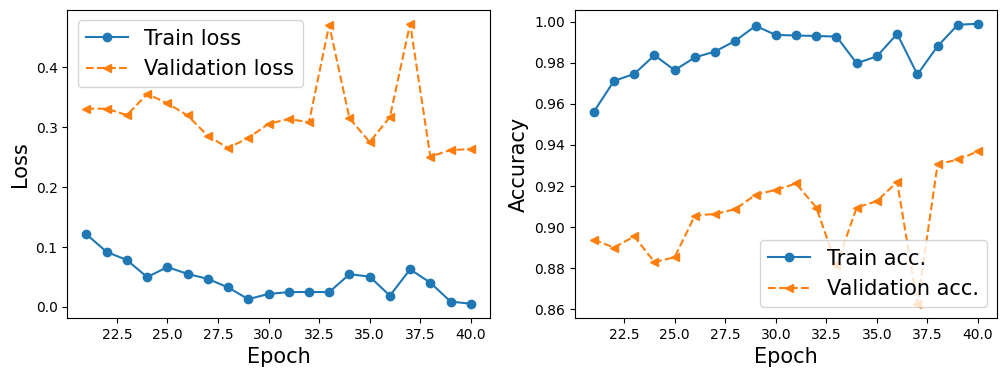

In [ ]:
x_arr = np.arange(20, 20+len(hist_doszko[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_doszko[0], '-o', label='Train loss')
ax.plot(x_arr, hist_doszko[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_doszko[2], '-o', label='Train acc.')
ax.plot(x_arr, hist_doszko[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

Obserwujemy, już nie tak wyraźną i występującymi z pewnymi zaburzeniami, ale nadal wzrostową, tendencję. Kontynuujemy.

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist_doszko_x2 = train(model1, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9995 val_accuracy: 0.9336
Epoch 2 accuracy: 0.9984 val_accuracy: 0.9172
Epoch 3 accuracy: 0.9922 val_accuracy: 0.9172
Epoch 4 accuracy: 0.9987 val_accuracy: 0.9250
Epoch 5 accuracy: 0.9906 val_accuracy: 0.8906
Epoch 6 accuracy: 0.9909 val_accuracy: 0.9227
Epoch 7 accuracy: 0.9888 val_accuracy: 0.8992
Epoch 8 accuracy: 0.9935 val_accuracy: 0.9320
Epoch 9 accuracy: 0.9956 val_accuracy: 0.9125
Epoch 10 accuracy: 0.9904 val_accuracy: 0.9109
Epoch 11 accuracy: 0.9937 val_accuracy: 0.9227
Epoch 12 accuracy: 0.9880 val_accuracy: 0.9125
Epoch 13 accuracy: 0.9948 val_accuracy: 0.9047
Epoch 14 accuracy: 0.9945 val_accuracy: 0.9234
Epoch 15 accuracy: 0.9943 val_accuracy: 0.9195
Epoch 16 accuracy: 0.9987 val_accuracy: 0.9383
Epoch 17 accuracy: 0.9995 val_accuracy: 0.9406
Epoch 18 accuracy: 1.0000 val_accuracy: 0.9445
Epoch 19 accuracy: 1.0000 val_accuracy: 0.9461
Epoch 20 accuracy: 1.0000 val_accuracy: 0.9391


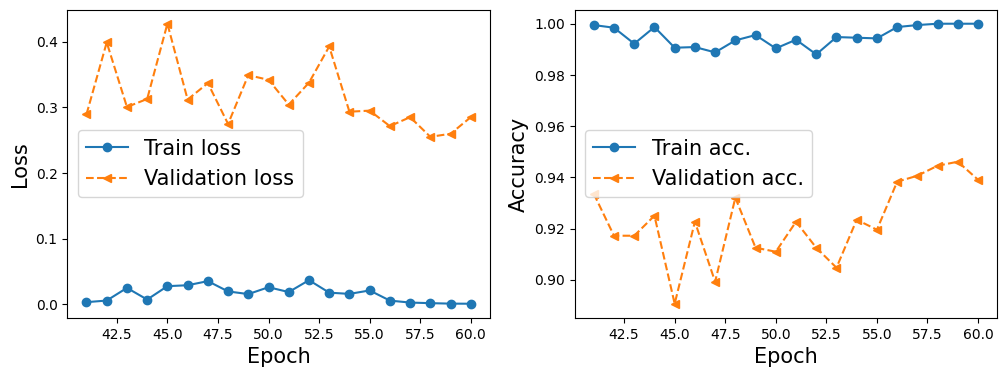

In [ ]:
x_arr = np.arange(40, 40+len(hist_doszko_x2[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_doszko_x2[0], '-o', label='Train loss')
ax.plot(x_arr, hist_doszko_x2[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_doszko_x2[2], '-o', label='Train acc.')
ax.plot(x_arr, hist_doszko_x2[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
torch.save(model1, 'model1.pth')

In [ ]:
model1 = torch.load('model1.pth')

Dokładność na walidzie ustabilizowała się na poziomie około 94%. Nie jest źle. Czy może być lepiej?

### Model 2

In [ ]:
if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")
else:
    print('OK')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
in_out = [3, 50, 50, 50, 50]

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=in_out[0], out_channels=in_out[1], kernel_size=15, padding=7))
model.add_module('elu1', nn.ELU())
model.add_module('pool1', nn.AvgPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=in_out[1], out_channels=in_out[2], kernel_size=11, padding=5))
model.add_module('elu2', nn.ELU())
model.add_module('pool2', nn.AvgPool2d(kernel_size=2))
model.add_module('conv3', nn.Conv2d(in_channels=in_out[2], out_channels=in_out[3], kernel_size=7, padding=3))
model.add_module('elu3', nn.ELU())
model.add_module('pool3', nn.AvgPool2d(kernel_size=2))
model.add_module('conv4', nn.Conv2d(in_channels=in_out[3], out_channels=in_out[4], kernel_size=5, padding=2))
model.add_module('elu4', nn.ELU())
model.add_module('pool4', nn.AvgPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(50*8*8, 1024)) # 50 map 8x8
model.add_module('relu5', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.25))
model.add_module('fc2', nn.Linear(1024, 1024))
model.add_module('relu6', nn.ReLU())
model.add_module('dropout2', nn.Dropout(p=0.25))
model.add_module('fc3', nn.Linear(1024, 4))

model2 = model
model2 = model2.to(device)

In [ ]:
x = torch.ones((4, 3, 128, 128)).to(device)
model2(x)

tensor([[ 0.0002,  0.0054,  0.0271,  0.0072],
        [-0.0176,  0.0126,  0.0314,  0.0017],
        [-0.0129,  0.0272,  0.0345, -0.0024],
        [-0.0011,  0.0181,  0.0435, -0.0010]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist2 = train(model2, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.4549 val_accuracy: 0.4781
Epoch 2 accuracy: 0.4992 val_accuracy: 0.3617
Epoch 3 accuracy: 0.4891 val_accuracy: 0.4977
Epoch 4 accuracy: 0.5130 val_accuracy: 0.5133
Epoch 5 accuracy: 0.5036 val_accuracy: 0.4898
Epoch 6 accuracy: 0.5188 val_accuracy: 0.5086
Epoch 7 accuracy: 0.4898 val_accuracy: 0.4781
Epoch 8 accuracy: 0.5099 val_accuracy: 0.4891
Epoch 9 accuracy: 0.5167 val_accuracy: 0.4773
Epoch 10 accuracy: 0.5081 val_accuracy: 0.4781
Epoch 11 accuracy: 0.4974 val_accuracy: 0.5125
Epoch 12 accuracy: 0.4979 val_accuracy: 0.4891
Epoch 13 accuracy: 0.5263 val_accuracy: 0.4922
Epoch 14 accuracy: 0.5154 val_accuracy: 0.4781
Epoch 15 accuracy: 0.5135 val_accuracy: 0.4898
Epoch 16 accuracy: 0.5055 val_accuracy: 0.4914
Epoch 17 accuracy: 0.5117 val_accuracy: 0.4969
Epoch 18 accuracy: 0.5245 val_accuracy: 0.4914
Epoch 19 accuracy: 0.5070 val_accuracy: 0.4844
Epoch 20 accuracy: 0.5083 val_accuracy: 0.4891


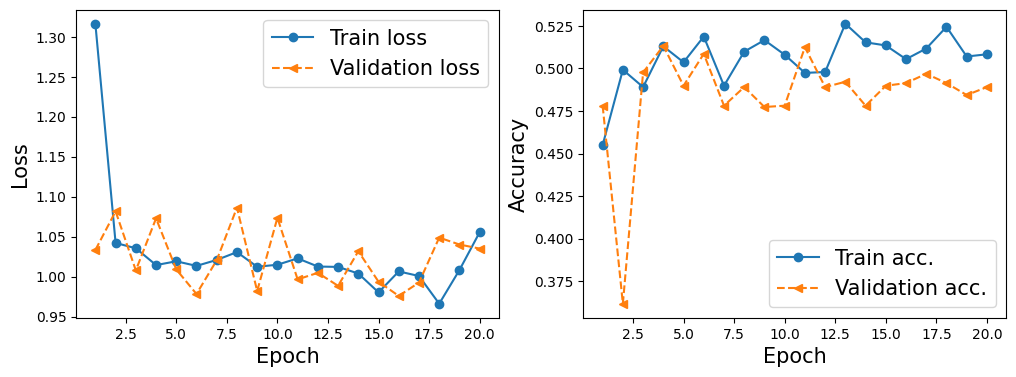

In [ ]:
x_arr = np.arange(len(hist2[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist2[0], '-o', label='Train loss')
ax.plot(x_arr, hist2[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist2[2], '-o', label='Train acc.')
ax.plot(x_arr, hist2[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

Dajmy mu jeszcze szansę. Może z nieco mniejszym `batch_size=8` i mniejszym `learning_rate=0.0002`.


In [ ]:
batch_size2 = 8
train_dl2 = DataLoader(train_dataset, batch_size=batch_size2, shuffle=True)
valid_dl2 = DataLoader(valid_dataset, batch_size=batch_size2, shuffle=False)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0002)

def train2(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer2.step()
            optimizer2.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist22 = train2(model2, num_epochs, train_dl2, valid_dl2)

Epoch 1 accuracy: 0.5130 val_accuracy: 0.4781
Epoch 2 accuracy: 0.5250 val_accuracy: 0.5227
Epoch 3 accuracy: 0.5237 val_accuracy: 0.4859
Epoch 4 accuracy: 0.5245 val_accuracy: 0.5258
Epoch 5 accuracy: 0.5312 val_accuracy: 0.5219
Epoch 6 accuracy: 0.5273 val_accuracy: 0.5227
Epoch 7 accuracy: 0.5443 val_accuracy: 0.5109
Epoch 8 accuracy: 0.5276 val_accuracy: 0.5141
Epoch 9 accuracy: 0.5398 val_accuracy: 0.5250
Epoch 10 accuracy: 0.5404 val_accuracy: 0.5258
Epoch 11 accuracy: 0.5464 val_accuracy: 0.5539
Epoch 12 accuracy: 0.5526 val_accuracy: 0.5312
Epoch 13 accuracy: 0.5596 val_accuracy: 0.5805
Epoch 14 accuracy: 0.5625 val_accuracy: 0.5828
Epoch 15 accuracy: 0.5674 val_accuracy: 0.5688
Epoch 16 accuracy: 0.5745 val_accuracy: 0.6102
Epoch 17 accuracy: 0.5820 val_accuracy: 0.5852
Epoch 18 accuracy: 0.5979 val_accuracy: 0.5758
Epoch 19 accuracy: 0.6042 val_accuracy: 0.6070
Epoch 20 accuracy: 0.6180 val_accuracy: 0.6289


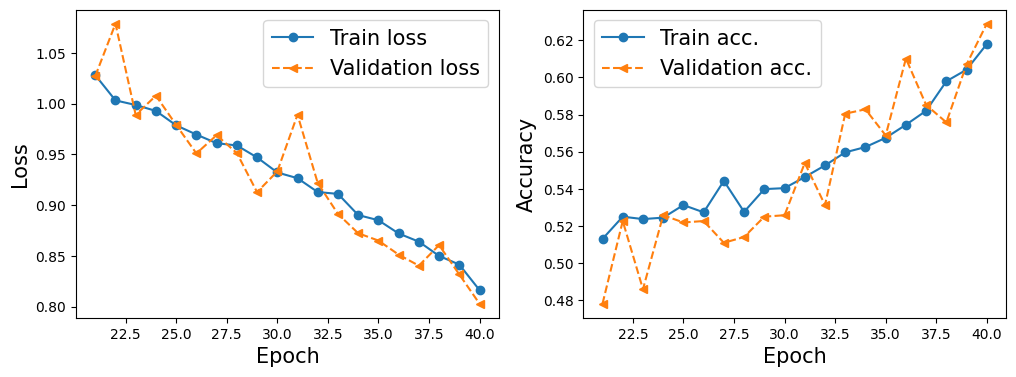

In [ ]:
x_arr = np.arange(20, 20+len(hist22[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist22[0], '-o', label='Train loss')
ax.plot(x_arr, hist22[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist22[2], '-o', label='Train acc.')
ax.plot(x_arr, hist22[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

Pomogło. Lecimy więc dalej.

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist222 = train2(model2, num_epochs, train_dl2, valid_dl2)

Epoch 1 accuracy: 0.6182 val_accuracy: 0.6555
Epoch 2 accuracy: 0.6513 val_accuracy: 0.6297
Epoch 3 accuracy: 0.6607 val_accuracy: 0.6406
Epoch 4 accuracy: 0.6573 val_accuracy: 0.6805
Epoch 5 accuracy: 0.6880 val_accuracy: 0.6922
Epoch 6 accuracy: 0.7026 val_accuracy: 0.6945
Epoch 7 accuracy: 0.7102 val_accuracy: 0.6672
Epoch 8 accuracy: 0.7203 val_accuracy: 0.7188
Epoch 9 accuracy: 0.7307 val_accuracy: 0.7430
Epoch 10 accuracy: 0.7594 val_accuracy: 0.7539
Epoch 11 accuracy: 0.7654 val_accuracy: 0.7469
Epoch 12 accuracy: 0.7870 val_accuracy: 0.7508
Epoch 13 accuracy: 0.7964 val_accuracy: 0.7727
Epoch 14 accuracy: 0.8154 val_accuracy: 0.7688
Epoch 15 accuracy: 0.8289 val_accuracy: 0.8031
Epoch 16 accuracy: 0.8432 val_accuracy: 0.8172
Epoch 17 accuracy: 0.8490 val_accuracy: 0.8234
Epoch 18 accuracy: 0.8596 val_accuracy: 0.8344
Epoch 19 accuracy: 0.8763 val_accuracy: 0.8539
Epoch 20 accuracy: 0.8721 val_accuracy: 0.8594


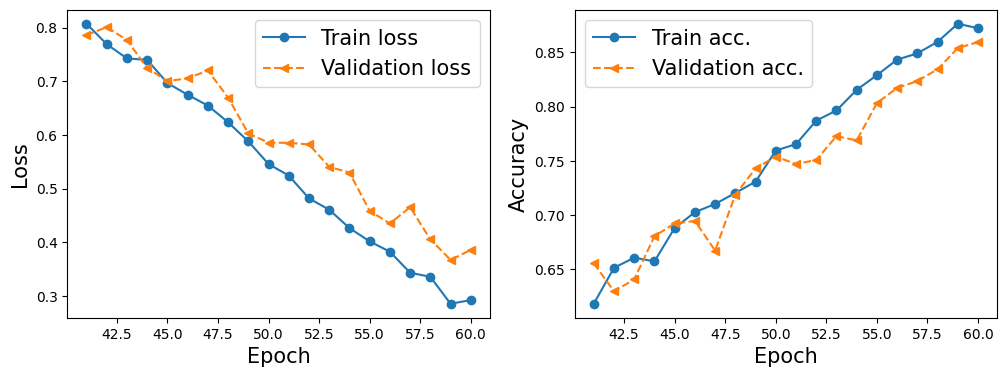

In [ ]:
x_arr = np.arange(40, 40+len(hist222[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist222[0], '-o', label='Train loss')
ax.plot(x_arr, hist222[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist222[2], '-o', label='Train acc.')
ax.plot(x_arr, hist222[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

Idziemy w dobrym kierunku...

In [ ]:
torch.save(model2, 'model2.pth')

In [ ]:
#model = torch.load('model2.pth')
#model.eval()

Doszkalamy teraz nieco mniejszymi porcjami (po 5 epok), by uodpornić się na ewentualne przyszłe spadki dokładności.

In [ ]:
torch.manual_seed(1)

num_epochs = 5
hist2222 = train2(model2, num_epochs, train_dl2, valid_dl2)

Epoch 1 accuracy: 0.8961 val_accuracy: 0.8289
Epoch 2 accuracy: 0.9008 val_accuracy: 0.8500
Epoch 3 accuracy: 0.9057 val_accuracy: 0.8523
Epoch 4 accuracy: 0.9115 val_accuracy: 0.8867
Epoch 5 accuracy: 0.9216 val_accuracy: 0.8641


Dokładność rośnie...

In [ ]:
hist_2_temp = hist2222

In [ ]:
torch.manual_seed(1)

num_epochs = 5
hist2222 = train2(model2, num_epochs, train_dl2, valid_dl2)

Epoch 1 accuracy: 0.9320 val_accuracy: 0.8820
Epoch 2 accuracy: 0.9401 val_accuracy: 0.8734
Epoch 3 accuracy: 0.9401 val_accuracy: 0.8906
Epoch 4 accuracy: 0.9422 val_accuracy: 0.9141
Epoch 5 accuracy: 0.9414 val_accuracy: 0.9195


...i rośnie...

In [ ]:
a_temp = np.array(hist_2_temp)
b_temp = np.array(hist2222)
hist_2 = np.hstack((a_temp, b_temp))

In [ ]:
torch.save(model2, 'model2.pth')

In [ ]:
model2 = torch.load('model2.pth')

In [ ]:
torch.manual_seed(1)

num_epochs = 5
hist2222 = train2(model2, num_epochs, train_dl2, valid_dl2)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 accuracy: 0.9503 val_accuracy: 0.9250
Epoch 2 accuracy: 0.9490 val_accuracy: 0.9172
Epoch 3 accuracy: 0.9586 val_accuracy: 0.9133
Epoch 4 accuracy: 0.9557 val_accuracy: 0.9180
Epoch 5 accuracy: 0.9570 val_accuracy: 0.9008


...i spada :(

In [ ]:
a_temp = hist2222

Żeby zwiększyć stabilność rozwoju sieci, zmniejszymy dropout do `p=0.1`.

In [ ]:
print(model2)

Sequential(
  (conv1): Conv2d(3, 50, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
  (elu1): ELU(alpha=1.0)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(50, 50, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (elu2): ELU(alpha=1.0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(50, 50, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (elu3): ELU(alpha=1.0)
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (elu4): ELU(alpha=1.0)
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, out_features=1024, bias=True)
  (relu5): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu6): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=1024, out_features=4, 

In [ ]:
for module in model2.modules():
        if isinstance(module, nn.Dropout):
          module.p = 0.1

print(model2)

Sequential(
  (conv1): Conv2d(3, 50, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
  (elu1): ELU(alpha=1.0)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(50, 50, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (elu2): ELU(alpha=1.0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(50, 50, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (elu3): ELU(alpha=1.0)
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (elu4): ELU(alpha=1.0)
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, out_features=1024, bias=True)
  (relu5): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu6): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=1024, out_features=4, bi

In [ ]:
torch.manual_seed(1)

num_epochs = 5
hist2222 = train2(model2, num_epochs, train_dl2, valid_dl2)

Epoch 1 accuracy: 0.9792 val_accuracy: 0.9406
Epoch 2 accuracy: 0.9794 val_accuracy: 0.9289
Epoch 3 accuracy: 0.9815 val_accuracy: 0.9117
Epoch 4 accuracy: 0.9846 val_accuracy: 0.9258
Epoch 5 accuracy: 0.9836 val_accuracy: 0.9328


In [ ]:
a2_temp = hist2222

Dokładność nieco się poprawiła, ale nie chce monotonicznie rosnąć. Wyłączmy dropout całkowicie.

In [ ]:
for module in model2.modules():
        if isinstance(module, nn.Dropout):
          module.p = 0

print(model2)

Sequential(
  (conv1): Conv2d(3, 50, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
  (elu1): ELU(alpha=1.0)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(50, 50, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (elu2): ELU(alpha=1.0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(50, 50, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (elu3): ELU(alpha=1.0)
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (elu4): ELU(alpha=1.0)
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, out_features=1024, bias=True)
  (relu5): ReLU()
  (dropout): Dropout(p=0, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu6): ReLU()
  (dropout2): Dropout(p=0, inplace=False)
  (fc3): Linear(in_features=1024, out_features=4, bias=T

In [ ]:
torch.manual_seed(1)

num_epochs = 5
hist2222 = train2(model2, num_epochs, train_dl2, valid_dl2)

Epoch 1 accuracy: 0.9904 val_accuracy: 0.9203
Epoch 2 accuracy: 0.9833 val_accuracy: 0.9117
Epoch 3 accuracy: 0.9828 val_accuracy: 0.9422
Epoch 4 accuracy: 0.9984 val_accuracy: 0.8852
Epoch 5 accuracy: 0.9742 val_accuracy: 0.9305


Utknęliśmy w okolicach 93%. Model robi się też w trakcie uczenia coraz mniej stabilny.

In [ ]:
torch.save(model2, 'model2plus.pth')

In [ ]:
b2_temp = np.array(hist2222)
hist_2k = np.hstack((a2_temp, b2_temp))
hist_2k

array([[0.05762412, 0.06359174, 0.06288116, 0.0512758 , 0.04821105,
        0.03016136, 0.04382944, 0.04645346, 0.0062714 , 0.08716408],
       [0.20290188, 0.25283977, 0.36238512, 0.28596233, 0.27897265,
        0.33646064, 0.46571335, 0.23013984, 0.58029371, 0.29167023],
       [0.97916669, 0.9794271 , 0.9815104 , 0.98463541, 0.98359376,
        0.99036461, 0.98333335, 0.98281252, 0.99843752, 0.97421873],
       [0.94062501, 0.92890626, 0.91171873, 0.92578125, 0.93281251,
        0.92031252, 0.91171873, 0.94218749, 0.88515627, 0.93046874]])

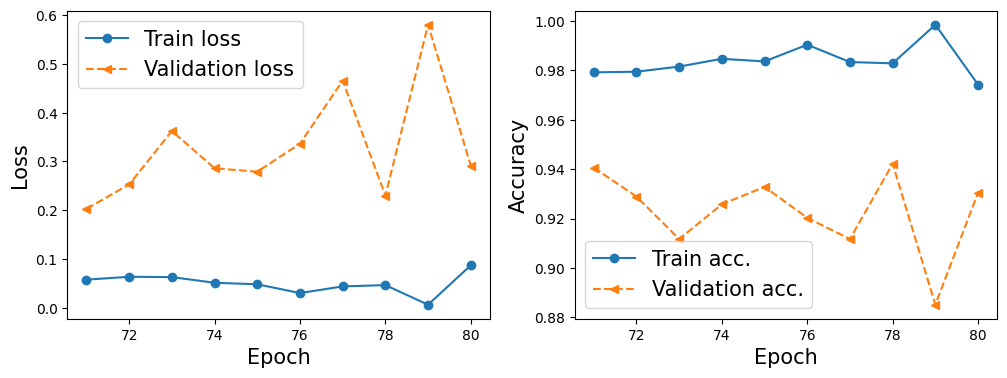

In [ ]:
x_arr = np.arange(70, 70+len(hist_2k[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_2k[0], '-o', label='Train loss')
ax.plot(x_arr, hist_2k[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_2k[2], '-o', label='Train acc.')
ax.plot(x_arr, hist_2k[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

## Model 3

In [ ]:
if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")
else:
    print('OK')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OK


In [ ]:
in_out = [3, 16, 32, 64]

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=in_out[0], out_channels=in_out[1], kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=in_out[1], out_channels=in_out[2], kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('conv3', nn.Conv2d(in_channels=in_out[2], out_channels=in_out[3], kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(16*16*64, 128))
model.add_module('relu4', nn.ReLU())
model.add_module('fc2', nn.Linear(128, 4))

model3 = model
model3 = model3.to(device)

In [ ]:
batch_size3 = 16
train_dl3 = DataLoader(train_dataset, batch_size=batch_size3, shuffle=True)
valid_dl3 = DataLoader(valid_dataset, batch_size=batch_size3, shuffle=False)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist3 = train(model3, num_epochs, train_dl3, valid_dl3)

Epoch 1 accuracy: 0.5005 val_accuracy: 0.4828
Epoch 2 accuracy: 0.5576 val_accuracy: 0.6148
Epoch 3 accuracy: 0.6404 val_accuracy: 0.6875
Epoch 4 accuracy: 0.7409 val_accuracy: 0.7063
Epoch 5 accuracy: 0.8365 val_accuracy: 0.8234
Epoch 6 accuracy: 0.9161 val_accuracy: 0.8602
Epoch 7 accuracy: 0.9484 val_accuracy: 0.8938
Epoch 8 accuracy: 0.9638 val_accuracy: 0.9102
Epoch 9 accuracy: 0.9901 val_accuracy: 0.9273
Epoch 10 accuracy: 0.9971 val_accuracy: 0.8836
Epoch 11 accuracy: 0.9779 val_accuracy: 0.9266
Epoch 12 accuracy: 0.9914 val_accuracy: 0.9148
Epoch 13 accuracy: 0.9922 val_accuracy: 0.9312
Epoch 14 accuracy: 0.9930 val_accuracy: 0.9375
Epoch 15 accuracy: 0.9937 val_accuracy: 0.9344
Epoch 16 accuracy: 0.9943 val_accuracy: 0.9180
Epoch 17 accuracy: 0.9891 val_accuracy: 0.9070
Epoch 18 accuracy: 0.9870 val_accuracy: 0.9422
Epoch 19 accuracy: 0.9992 val_accuracy: 0.9563
Epoch 20 accuracy: 1.0000 val_accuracy: 0.9563


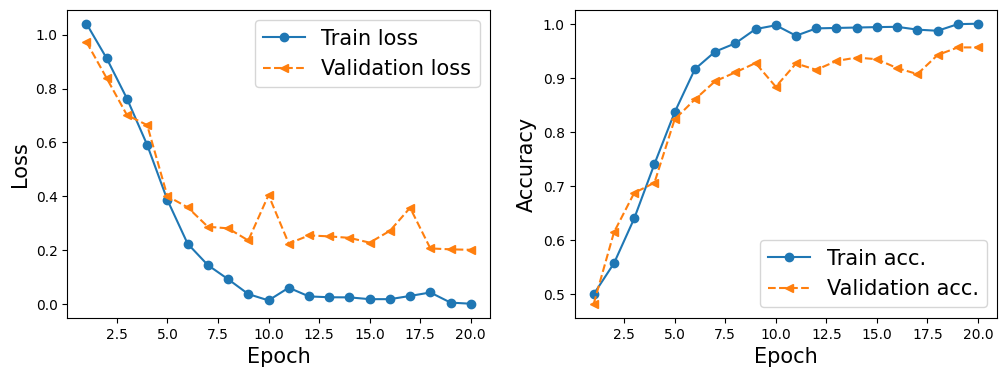

In [ ]:
x_arr = np.arange(len(hist3[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist3[0], '-o', label='Train loss')
ax.plot(x_arr, hist3[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist3[2], '-o', label='Train acc.')
ax.plot(x_arr, hist3[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
torch.save(model3, 'model3.pth')

Model powoli się stabilizuje. Zmniejszmy tempo uczenia i kontynuujmy naukę.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0002)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist33 = train(model3, num_epochs, train_dl3, valid_dl3)

Epoch 1 accuracy: 1.0000 val_accuracy: 0.9594
Epoch 2 accuracy: 0.9990 val_accuracy: 0.9586
Epoch 3 accuracy: 1.0000 val_accuracy: 0.9617
Epoch 4 accuracy: 1.0000 val_accuracy: 0.9633
Epoch 5 accuracy: 1.0000 val_accuracy: 0.9633
Epoch 6 accuracy: 1.0000 val_accuracy: 0.9633
Epoch 7 accuracy: 1.0000 val_accuracy: 0.9617
Epoch 8 accuracy: 1.0000 val_accuracy: 0.9625
Epoch 9 accuracy: 1.0000 val_accuracy: 0.9625
Epoch 10 accuracy: 1.0000 val_accuracy: 0.9625
Epoch 11 accuracy: 1.0000 val_accuracy: 0.9625
Epoch 12 accuracy: 1.0000 val_accuracy: 0.9625
Epoch 13 accuracy: 1.0000 val_accuracy: 0.9633
Epoch 14 accuracy: 1.0000 val_accuracy: 0.9633
Epoch 15 accuracy: 1.0000 val_accuracy: 0.9633
Epoch 16 accuracy: 1.0000 val_accuracy: 0.9633
Epoch 17 accuracy: 1.0000 val_accuracy: 0.9633
Epoch 18 accuracy: 1.0000 val_accuracy: 0.9641
Epoch 19 accuracy: 1.0000 val_accuracy: 0.9641
Epoch 20 accuracy: 1.0000 val_accuracy: 0.9641


In [ ]:
torch.save(model3, 'model3.pth')

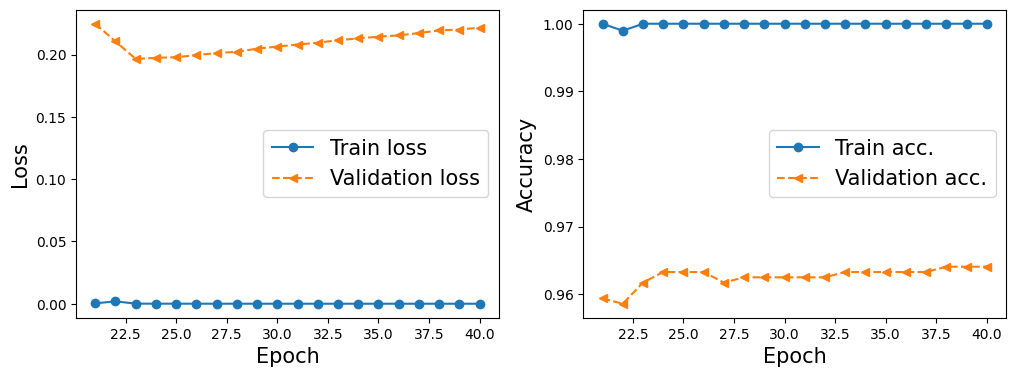

In [ ]:
x_arr = np.arange(20, 20+len(hist33[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist33[0], '-o', label='Train loss')
ax.plot(x_arr, hist33[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist33[2], '-o', label='Train acc.')
ax.plot(x_arr, hist33[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

96%. To jest to!

## Model 3.5 - dostrajanie

Model 3 wypadł najlepiej. Zachowamy więc jego strukturę, a zmodyfikujemy filtry, typ poolingu i dodamy dropout w sieci FC.

In [ ]:
if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")
else:
    print('OK')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OK


In [ ]:
in_out = [3, 20, 40, 30]

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=in_out[0], out_channels=in_out[1], kernel_size=7, padding=2))
model.add_module('elu1', nn.ELU())
model.add_module('pool1', nn.AvgPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=in_out[1], out_channels=in_out[2], kernel_size=6, padding=2))
model.add_module('elu2', nn.ELU())
model.add_module('pool2', nn.AvgPool2d(kernel_size=2))
model.add_module('conv3', nn.Conv2d(in_channels=in_out[2], out_channels=in_out[3], kernel_size=6, padding=2))
model.add_module('elu3', nn.ELU())
model.add_module('pool4', nn.AvgPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(6750, 1024))
model.add_module('relu4', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 4))  # 4 etykiety

model35 = model
model35 = model35.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model35, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.4487 val_accuracy: 0.4883
Epoch 2 accuracy: 0.5201 val_accuracy: 0.5063
Epoch 3 accuracy: 0.5443 val_accuracy: 0.5422
Epoch 4 accuracy: 0.5805 val_accuracy: 0.5930
Epoch 5 accuracy: 0.5909 val_accuracy: 0.6195
Epoch 6 accuracy: 0.6411 val_accuracy: 0.6414
Epoch 7 accuracy: 0.6883 val_accuracy: 0.6945
Epoch 8 accuracy: 0.7294 val_accuracy: 0.7281
Epoch 9 accuracy: 0.7846 val_accuracy: 0.7875
Epoch 10 accuracy: 0.8263 val_accuracy: 0.8250
Epoch 11 accuracy: 0.8687 val_accuracy: 0.8547
Epoch 12 accuracy: 0.9076 val_accuracy: 0.9195
Epoch 13 accuracy: 0.9216 val_accuracy: 0.9148
Epoch 14 accuracy: 0.9380 val_accuracy: 0.9344
Epoch 15 accuracy: 0.9628 val_accuracy: 0.9461
Epoch 16 accuracy: 0.9622 val_accuracy: 0.9484
Epoch 17 accuracy: 0.9755 val_accuracy: 0.9430
Epoch 18 accuracy: 0.9703 val_accuracy: 0.9648
Epoch 19 accuracy: 0.9763 val_accuracy: 0.9570
Epoch 20 accuracy: 0.9779 val_accuracy: 0.9508


Świetne dostrojenie! Sieć w 18-stej epoce osiągnęła wyniki lepsze niż w modelu3 po 40 epokach.

In [ ]:
torch.save(model35, 'model35.pth')

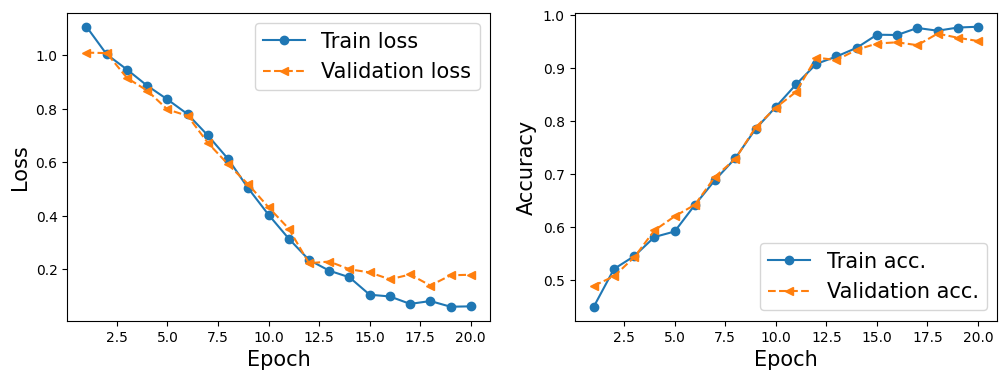

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
hist35 = np.array(hist)

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model35, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9797 val_accuracy: 0.9617
Epoch 2 accuracy: 0.9828 val_accuracy: 0.9656
Epoch 3 accuracy: 0.9880 val_accuracy: 0.9656
Epoch 4 accuracy: 0.9820 val_accuracy: 0.9563
Epoch 5 accuracy: 0.9831 val_accuracy: 0.9664
Epoch 6 accuracy: 0.9867 val_accuracy: 0.9617
Epoch 7 accuracy: 0.9797 val_accuracy: 0.9656
Epoch 8 accuracy: 0.9836 val_accuracy: 0.9617
Epoch 9 accuracy: 0.9888 val_accuracy: 0.9555
Epoch 10 accuracy: 0.9919 val_accuracy: 0.9734
Epoch 11 accuracy: 0.9909 val_accuracy: 0.9680
Epoch 12 accuracy: 0.9901 val_accuracy: 0.9695
Epoch 13 accuracy: 0.9872 val_accuracy: 0.9547
Epoch 14 accuracy: 0.9901 val_accuracy: 0.9680
Epoch 15 accuracy: 0.9849 val_accuracy: 0.9633
Epoch 16 accuracy: 0.9909 val_accuracy: 0.9656
Epoch 17 accuracy: 0.9924 val_accuracy: 0.9781
Epoch 18 accuracy: 0.9924 val_accuracy: 0.9641
Epoch 19 accuracy: 0.9930 val_accuracy: 0.9633
Epoch 20 accuracy: 0.9867 val_accuracy: 0.9695


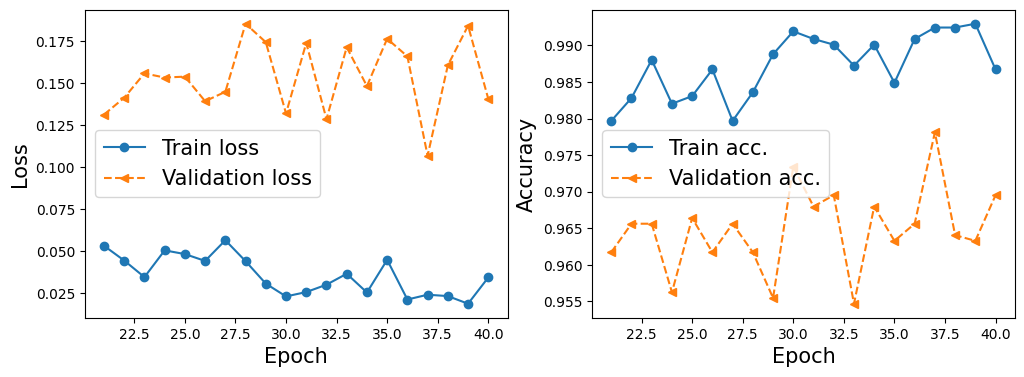

In [ ]:
x_arr = np.arange(20, 20+len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
torch.save(model35, 'model35.pth')

In [ ]:
a_temp = hist35
b_temp = np.array(hist)
hist35 = np.hstack((a_temp, b_temp))
hist35

array([[1.10718974, 1.00370324, 0.94720362, 0.88684746, 0.8354707 ,
        0.7803808 , 0.70081901, 0.61308564, 0.50283256, 0.40444858,
        0.31512018, 0.23553755, 0.19545787, 0.17060015, 0.10552435,
        0.09897636, 0.07111551, 0.0819003 , 0.0606142 , 0.0620254 ,
        0.05313775, 0.04430966, 0.03444173, 0.05038401, 0.04817406,
        0.04409444, 0.05642334, 0.04394102, 0.03054669, 0.02292733,
        0.02552152, 0.02992337, 0.03644329, 0.02527372, 0.04474139,
        0.02108624, 0.0239457 , 0.02312469, 0.0185716 , 0.03422745],
       [1.01047492, 1.00853047, 0.91583791, 0.86859986, 0.7980405 ,
        0.77408496, 0.67312025, 0.59299923, 0.51770157, 0.43234461,
        0.35230689, 0.22320974, 0.22947491, 0.2006274 , 0.18874878,
        0.16303174, 0.181114  , 0.13976927, 0.17801384, 0.18020483,
        0.13133216, 0.14139957, 0.15591496, 0.15342856, 0.15396932,
        0.13933122, 0.14492668, 0.1855235 , 0.17450799, 0.13204131,
        0.17406219, 0.1286131 , 0.17149763, 0.1

In [ ]:
batch_size35 = 10
train_dl35 = DataLoader(train_dataset, batch_size=batch_size35, shuffle=True)
valid_dl35 = DataLoader(valid_dataset, batch_size=batch_size35, shuffle=False)

In [ ]:
optimizer35 = torch.optim.Adam(model35.parameters(), lr=0.0002)

def train35(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer35.step()
            optimizer35.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        if accuracy_hist_valid[epoch] > accuracy_hist_valid[epoch-1]:
            torch.save(model35, 'model35ep{0}.pth'.format(epoch+1))

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

W powyższym trainie() dodaliśmy też zapisywanie każdego modelu lepszego od poprzedniego.

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train35(model35, num_epochs, train_dl35, valid_dl35)

Epoch 1 accuracy: 0.9935 val_accuracy: 0.9742
Epoch 2 accuracy: 0.9945 val_accuracy: 0.9797
Epoch 3 accuracy: 0.9966 val_accuracy: 0.9773
Epoch 4 accuracy: 0.9966 val_accuracy: 0.9773
Epoch 5 accuracy: 0.9953 val_accuracy: 0.9789
Epoch 6 accuracy: 0.9958 val_accuracy: 0.9711
Epoch 7 accuracy: 0.9945 val_accuracy: 0.9688
Epoch 8 accuracy: 0.9943 val_accuracy: 0.9672
Epoch 9 accuracy: 0.9958 val_accuracy: 0.9648
Epoch 10 accuracy: 0.9969 val_accuracy: 0.9695
Epoch 11 accuracy: 0.9974 val_accuracy: 0.9758
Epoch 12 accuracy: 0.9966 val_accuracy: 0.9750
Epoch 13 accuracy: 0.9982 val_accuracy: 0.9695
Epoch 14 accuracy: 0.9969 val_accuracy: 0.9695
Epoch 15 accuracy: 0.9945 val_accuracy: 0.9688
Epoch 16 accuracy: 0.9956 val_accuracy: 0.9727
Epoch 17 accuracy: 0.9958 val_accuracy: 0.9750
Epoch 18 accuracy: 0.9969 val_accuracy: 0.9742
Epoch 19 accuracy: 0.9982 val_accuracy: 0.9766
Epoch 20 accuracy: 0.9961 val_accuracy: 0.9727


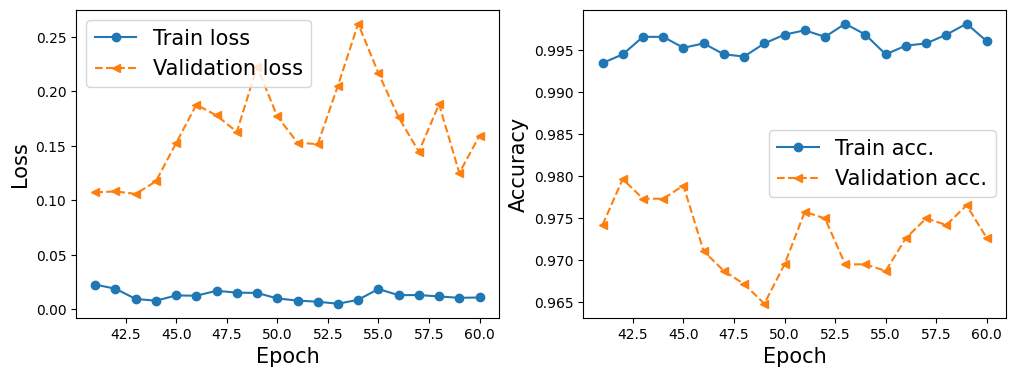

In [ ]:
x_arr = np.arange(40, 40+len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
a_temp = hist35
b_temp = np.array(hist)
hist35 = np.hstack((a_temp, b_temp))
hist35

array([[1.10718974, 1.00370324, 0.94720362, 0.88684746, 0.8354707 ,
        0.7803808 , 0.70081901, 0.61308564, 0.50283256, 0.40444858,
        0.31512018, 0.23553755, 0.19545787, 0.17060015, 0.10552435,
        0.09897636, 0.07111551, 0.0819003 , 0.0606142 , 0.0620254 ,
        0.05313775, 0.04430966, 0.03444173, 0.05038401, 0.04817406,
        0.04409444, 0.05642334, 0.04394102, 0.03054669, 0.02292733,
        0.02552152, 0.02992337, 0.03644329, 0.02527372, 0.04474139,
        0.02108624, 0.0239457 , 0.02312469, 0.0185716 , 0.03422745,
        0.02261138, 0.01883734, 0.00945272, 0.00783022, 0.01265156,
        0.01242622, 0.01694873, 0.01522086, 0.01498916, 0.00988902,
        0.00796592, 0.00685207, 0.00506138, 0.00868768, 0.01857561,
        0.01288404, 0.0130526 , 0.01171405, 0.01047308, 0.01080199],
       [1.01047492, 1.00853047, 0.91583791, 0.86859986, 0.7980405 ,
        0.77408496, 0.67312025, 0.59299923, 0.51770157, 0.43234461,
        0.35230689, 0.22320974, 0.22947491, 0.2

# Model ostateczny

Najlepiej wypadł model3.5. Łączymy zbiory treningowy i walidacyjny, i uczymy model. Sprawdzamy jakość testem.

In [ ]:
train_indices, rest_indices = train_test_split(range(len(dataset)), test_size=0.4, random_state=1234)
val_indices, test_indices = train_test_split(rest_indices, test_size=0.5, random_state=123)

TRAIN_indices = train_indices + val_indices

test_dataset = Subset(dataset, test_indices)
TRAIN_dataset = Subset(dataset, TRAIN_indices)

batch_size = 12
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
TRAIN_dl = DataLoader(TRAIN_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")
else:
    print('OK')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OK


In [ ]:
in_out = [3, 20, 40, 30]

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=in_out[0], out_channels=in_out[1], kernel_size=7, padding=2))
model.add_module('elu1', nn.ELU())
model.add_module('pool1', nn.AvgPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=in_out[1], out_channels=in_out[2], kernel_size=6, padding=2))
model.add_module('elu2', nn.ELU())
model.add_module('pool2', nn.AvgPool2d(kernel_size=2))
model.add_module('conv3', nn.Conv2d(in_channels=in_out[2], out_channels=in_out[3], kernel_size=6, padding=2))
model.add_module('elu3', nn.ELU())
model.add_module('pool4', nn.AvgPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(6750, 1024))
model.add_module('relu4', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 4))  # 4 etykiety

MODEL = model
MODEL = MODEL.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    best_acc = 0

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        if (epoch>5 and accuracy_hist_valid[epoch] > best_acc):
            torch.save(MODEL, 'MODELep{0}.pth'.format(epoch+1))
            best_acc = accuracy_hist_valid[epoch]

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} test_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 100
hist = train(MODEL, num_epochs, TRAIN_dl, test_dl)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 accuracy: 0.5246 test_accuracy: 0.5953
Epoch 2 accuracy: 0.5834 test_accuracy: 0.6250
Epoch 3 accuracy: 0.6434 test_accuracy: 0.6859
Epoch 4 accuracy: 0.7244 test_accuracy: 0.7773
Epoch 5 accuracy: 0.8178 test_accuracy: 0.8789
Epoch 6 accuracy: 0.8891 test_accuracy: 0.9086
Epoch 7 accuracy: 0.9414 test_accuracy: 0.9547
Epoch 8 accuracy: 0.9586 test_accuracy: 0.9797
Epoch 9 accuracy: 0.9670 test_accuracy: 0.9820
Epoch 10 accuracy: 0.9746 test_accuracy: 0.9750
Epoch 11 accuracy: 0.9762 test_accuracy: 0.9891
Epoch 12 accuracy: 0.9840 test_accuracy: 0.9875
Epoch 13 accuracy: 0.9811 test_accuracy: 0.9867
Epoch 14 accuracy: 0.9859 test_accuracy: 0.9906
Epoch 15 accuracy: 0.9848 test_accuracy: 0.9914
Epoch 16 accuracy: 0.9676 test_accuracy: 0.9953
Epoch 17 accuracy: 0.9900 test_accuracy: 0.9945
Epoch 18 accuracy: 0.9906 test_accuracy: 0.9922
Epoch 19 accuracy: 0.9918 test_accuracy: 0.9906
Epoch 20 accuracy: 0.9658 test_accuracy: 0.9875
Epoch 21 accuracy: 0.9875 test_accuracy: 0.9875
E

KeyboardInterrupt: 

99%. Przerywamy uczenie. Misja wykonana.

Wczytajmy model, który osiągnął największą dokładność - zdumiewające 99,9%.

In [ ]:
MODEL = torch.load('MODELep24.pth')

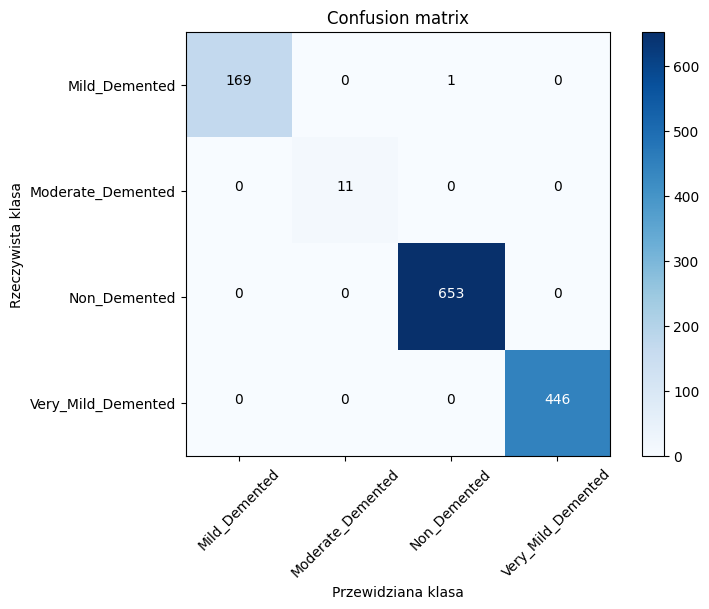

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(model, test_dl, class_names, device, title='Confusion matrix', cmap=plt.cm.Blues):

    model.eval()  # Ustawienie modelu w tryb ewaluacji

    true_labels = []
    predicted_labels = []

    # Iteracja przez dane testowe
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Przewidywanie
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    # Obliczenie macierzy pomyłek na CPU (numpy array)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Konfiguracja wykresu
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Formatowanie liczb na osiach
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")



    plt.tight_layout()
    plt.ylabel('Rzeczywista klasa')
    plt.xlabel('Przewidziana klasa')
    plt.grid(False)
    plt.show()


class_names = dataset.classes
plot_confusion_matrix(MODEL, test_dl, class_names, device, title='Confusion matrix', cmap=plt.cm.Blues)